# 클래스 분포 확인

In [1]:
import pandas as pd
from pathlib import Path
from hashlib import sha1
from PIL import Image
import matplotlib.pyplot as plt
from rich import print
from math import ceil
from shutil import move
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# train 디렉터리 경로를 입력해주세요
ROOT = Path('/opt/ml/input/data/train')

In [3]:
df = pd.read_csv(ROOT / 'train.csv')
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [4]:
def is_image(path):
    p = str(path)
    exts = ['jpg', 'png', 'jpeg']
    return '._' not in p and any(p.endswith(ext) for ext in exts)

def myglob(path, endswith='.*'):
    path = str(path)
    paths = list(ROOT.glob(f'**/*{path}*/*{endswith}'))
    return [p for p in paths if is_image(p)]

def show(paths):
    n = len(paths)
    n = ceil(n ** 0.5)
    
    plt.figure(figsize=(12, 12))
    plt.tight_layout()
    for i, p in enumerate(paths, start=1):
        im = Image.open(p)
        plt.subplot(n, n, i)
        plt.axis('off')
        plt.title(p.name)
        plt.imshow(im)

def gs(glob):
    paths = myglob(glob)
    print(paths)
    show(paths)

def gss(globs):
    for g in globs:
        gs(g)

def hash(path):
    with open(path, 'rb') as f:
        return sha1(f.read()).hexdigest()
    
def swap(p1, p2):
    pt = ROOT / 'tmp'
    p1.rename(pt)
    p2.rename(p1)
    pt.rename(p2)

In [5]:
import os
import re
import glob
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

class MaskGlobDataset(Dataset):
    def __init__(self, root, transform, train=True, paths=None):
        """
        csv 없이 파일 경로에서 라벨을 추출하는 데이터셋
        OfflineAug를 위해 제작함
        Args:
            root: 이미지가 들어있는 최상위 디렉터리
                  ex) '/opt/ml/input/data/train'
            transform:
            train:
        """
        self.root = root = Path(root)
        self.train = train
        self.transform = transform

        self.paths = []
        self.labels = []

        if paths is None:
            files = root.glob('**/*')
            self.paths = [f for f in files if self._is_image(f)]
        else:
            for path in paths:
                files = (root / 'images' / path).glob('*.*')
                files = [f for f in files if self._is_image(f)]
                self.paths.extend(files)

        if train:
            for p in self.paths:
                self.labels.append(self._parse(p))


    def _is_image(self, path):
        exts = ['jpg', 'jpeg', 'png']
        p = str(path)
        return '._' not in p and any(p.endswith(ext) for ext in exts)


    def _parse(self, p):
        """
        path를 파싱해 라벨 리턴
        """
        p = str(p)
        match = re.search('_(.+)_Asian_(\d+)/(.*)[\.-]', p)
        if match and len(match.groups()) == 3:
            gender, age, mask = match.groups()
            gender = 0 if gender == 'male' else 1
            age = int(age)
            if age < 30:
                age = 0
            elif age < 60:
                age = 1
            else:
                age = 2

            if mask.startswith('normal'):
                mask = 2
            elif mask.startswith('incorrect'):
                mask = 1
            else:
                mask = 0

            return str((mask, gender,  age))
        else:
            raise Exception(f'Cannot parsing label from the path: {p}')


    def __getitem__(self, index):
        image = Image.open(self.paths[index])
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.labels[index]
            return image, label
        return image, -1

    def __len__(self):
        return len(self.paths)

In [6]:
ds = MaskGlobDataset('/opt/ml/input/data/train', None)

In [7]:
l = ds.labels

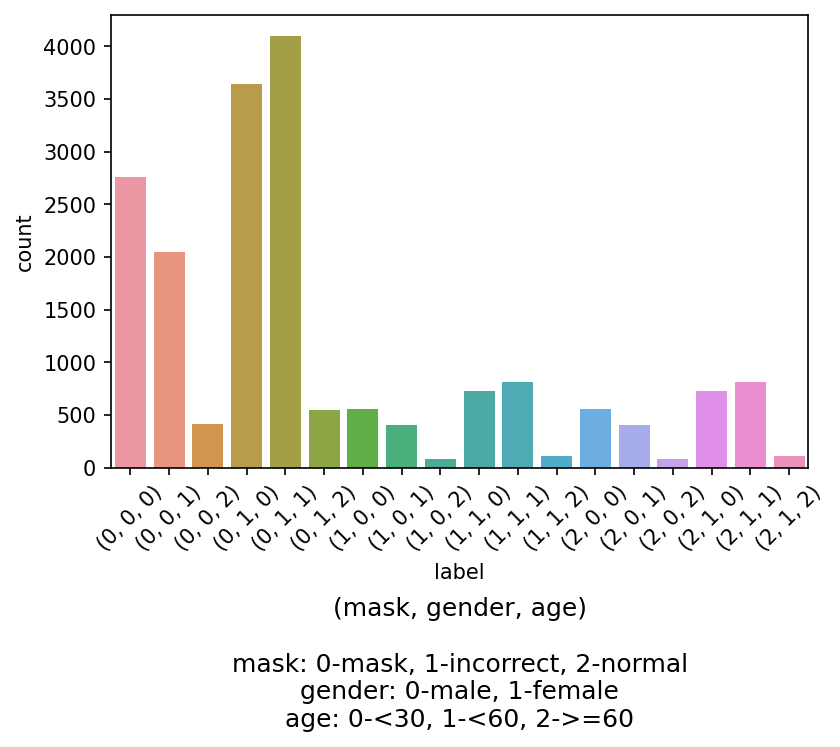

In [8]:
df = pd.DataFrame(l, columns=['label'])

plt.figure(dpi=150)
plt.xticks(rotation=45)
plt.title('(mask, gender, age)\n\nmask: 0-mask, 1-incorrect, 2-normal\ngender: 0-male, 1-female\nage: 0-<30, 1-<60, 2->=60', y=-0.6)
sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))

In [9]:
df.head()

,label
0,"(0, 1, 2)"
1,"(2, 1, 2)"
2,"(0, 1, 2)"
3,"(0, 1, 2)"
4,"(0, 1, 2)"


In [13]:
df = pd.read_csv(ROOT / 'train.csv')
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [53]:
def age2code(age):
    if age < 30:
        return 0
    elif age < 56:
        return 1
    return 2
df['gender_'] = df['gender'].map({'male': 0, 'female': 1})
df['age_'] = df['age'].apply(age2code)

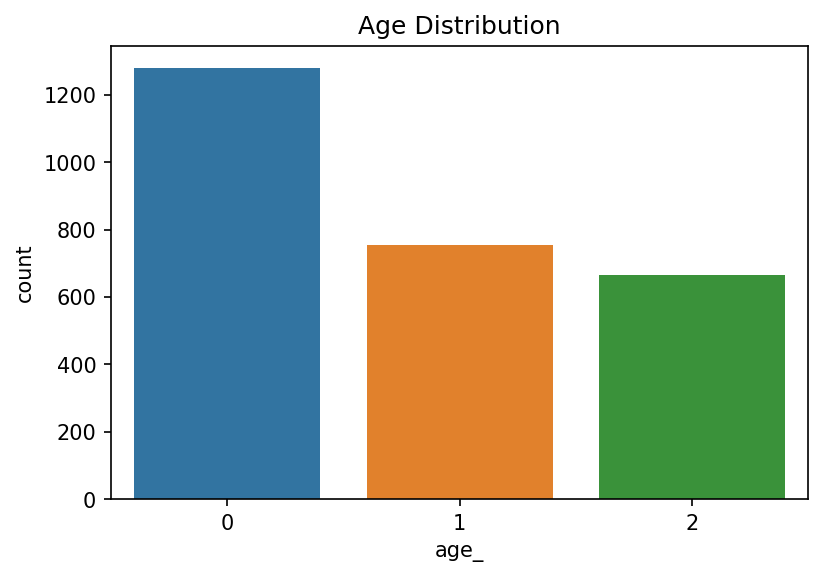

In [54]:
plt.figure(dpi=150)
plt.title('Age Distribution')
sns.countplot(x='age_', data=df)

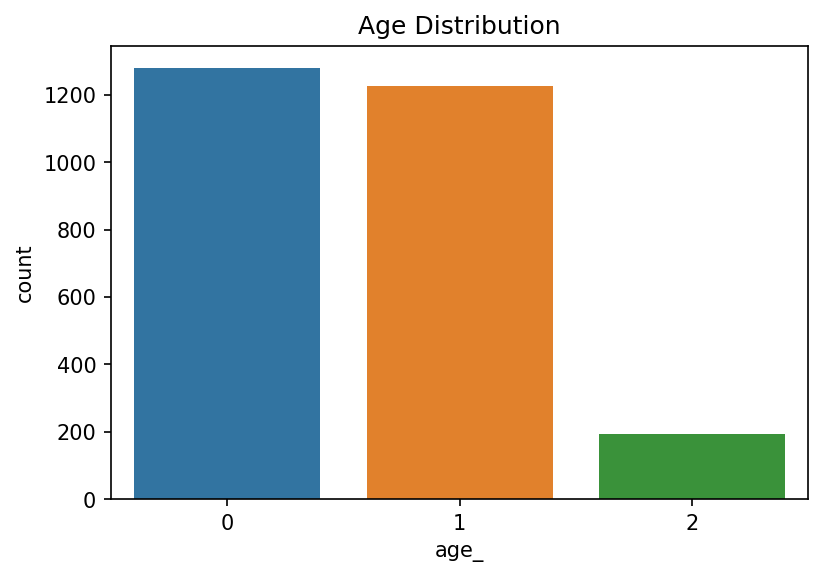

In [50]:
plt.figure(dpi=150)
plt.title('Age Distribution')
sns.countplot(x='age_', data=df)

<AxesSubplot:title={'center':'Gender Distribution'}, xlabel='gender_', ylabel='count'>

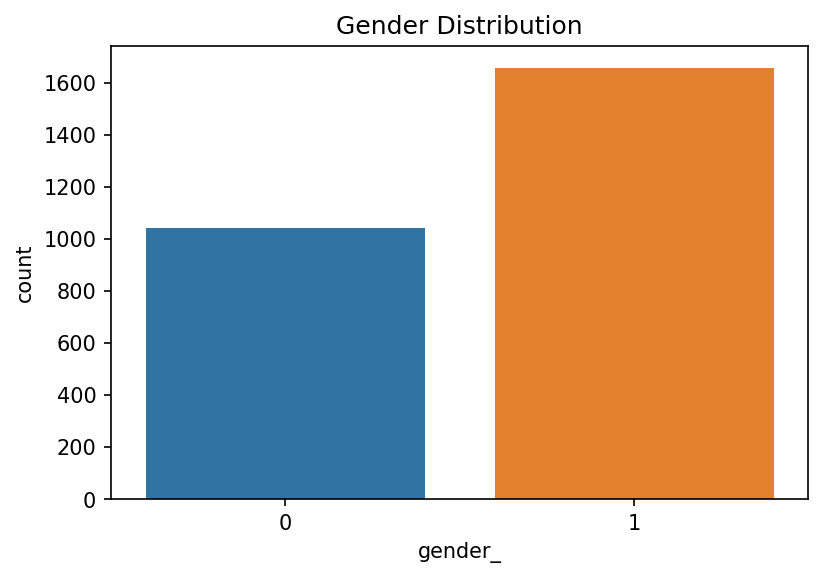

In [122]:
plt.figure(dpi=150)
plt.title('Gender Distribution')
sns.countplot(x='gender_', data=df)

In [137]:
df['class'] = df['gender'] + '_' + df['age_'].map({0: '-29', 1: '30-59', 2: '60-'}).apply(str)

<AxesSubplot:title={'center':'Gender-Age Distribution'}, xlabel='class', ylabel='count'>

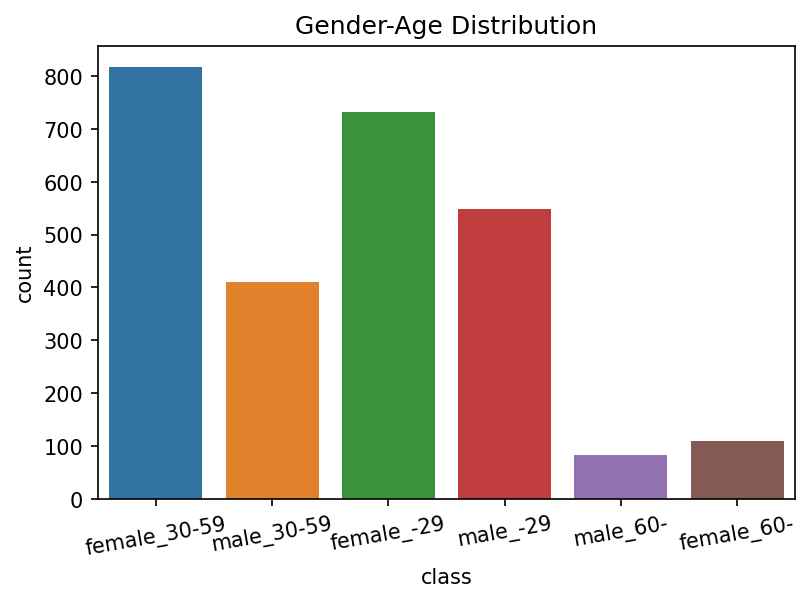

In [145]:
plt.figure(dpi=150)
plt.xticks(rotation=10)
plt.title('Gender-Age Distribution')

sns.countplot(x='class', data=df)